<h1>Задача «Классификация агрокультур на основе изменения показателя вегетационных индексов во временной последовательности»

<H2>Условие задачи

Перед участниками чемпионата стоит
задача
классификации
агрокультур на основе изменения показателя вегетационных индексов во
временной последовательности. Созданная за время чемпионата модель
поможет оптимизировать рабочие процессы в сфере сельского хозяйства,
обеспечить
органы
власти
актуальными
и
достоверными
сведениями,
увеличить социальный, инвестиционный и производственный потенциал
отрасли,
а
также
повысить
достоверность
и
удобство использования
информации о сельскохозяйственных объектах.

<h3>Описание входных значений</h3>

● train.csv — файл, содержащий данные о поле и временные ряды

● test.csv — файл, содержащий данные для предсказания

● sample_solution.csv — пример файла для отправки

**Пояснения к столбцам**



*   id – идентификатор объекта (поля)
*   area – площадь поля в га
*   nd mean YYYY-MM-DD – медианное значение вегетационного индекса
NDVI для данного поля на указанную дату
*   geo – координаты границ поля
*   crop – столбец для предсказания, содержит тип произрастающей
культуры по данным сельхозтоваропроизводителей

**Дополнительно расшифруем типы культур:**

0.   подсолнечник
1.   картофель
2.   пшеница озимая
3.   гречиха
4.   кукуруза
5.   пшеница яровая
6.   сахарная свекла


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
# импорт библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn import svm
import xgboost as xgb
import pylab as pl

from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import accuracy_score, recall_score, precision_score

import warnings
from warnings import filterwarnings
warnings.filterwarnings('error')
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
%matplotlib inline

RANDOM_STATE = 12345

In [5]:
# загрузка датасетов
try:
    df_train = pd.read_csv("/content/train_dataset_train.csv")
    df_test = pd.read_csv("/content/test_dataset_test.csv")
except:
    df_train = pd.read_csv('D:/Соревнования/Иннополис/train_dataset_train.csv')
    df_test = pd.read_csv('D:/Соревнования/Иннополис/test_dataset_test.csv')

In [6]:
# функция на первичную проверку данных
def df_check(dataset):
    print('Общая информация\n')
    display(dataset.info())
    print('Первые строки датасета\n')
    display(dataset.head())
    print('Описательная статистика\n')
    display(dataset.describe())
    print('Описательная статистика столбцов object\n')
    display(dataset.describe(include=['object', 'bool']))
    print('Количество пропусков в каждом столбце\n')
    display(dataset.isna().sum())
    print('Количество уникальных значений\n')
    display(dataset.nunique())
    print('Количество дубликатов\n')
    display(dataset.duplicated().sum())

In [7]:
df_check(df_train)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4830 entries, 0 to 4829
Data columns (total 74 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4830 non-null   int64  
 1   area                4830 non-null   int64  
 2   nd_mean_2021-04-16  4830 non-null   float64
 3   nd_mean_2021-04-19  4830 non-null   float64
 4   nd_mean_2021-04-22  4830 non-null   float64
 5   nd_mean_2021-04-26  4830 non-null   float64
 6   nd_mean_2021-04-28  4830 non-null   float64
 7   nd_mean_2021-05-02  4830 non-null   float64
 8   nd_mean_2021-05-04  4830 non-null   float64
 9   nd_mean_2021-05-07  4830 non-null   float64
 10  nd_mean_2021-05-16  4830 non-null   float64
 11  nd_mean_2021-05-17  4830 non-null   float64
 12  nd_mean_2021-05-21  4830 non-null   float64
 13  nd_mean_2021-05-26  4830 non-null   float64
 14  nd_mean_2021-05-27  4830 non-null   float64
 15  nd_mean_2021-05-29  4830 non-null   f

None

Первые строки датасета



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
0,3536,20,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.000000,...,0.108999,0.118854,0.000000,0.000000,0.026784,0.126832,0.614770,0.008857,0.081498,3
1,3739,45,0.332928,0.287182,0.097138,0.152467,0.075484,0.000000,0.140326,0.163340,...,0.134469,0.208268,0.000000,0.000000,0.111148,0.174914,0.179612,0.113071,0.046997,4
2,1294,28,0.013679,0.007055,0.120804,0.037839,0.259125,0.000000,0.037446,0.506516,...,0.084467,0.000000,0.210496,0.130467,0.155225,0.090607,0.054127,0.007437,0.219614,2
3,2859,19,0.105976,0.052500,0.001917,0.011531,0.042316,0.000000,0.000000,0.043604,...,0.000000,0.642226,0.132886,0.000000,0.570928,0.073492,0.378900,0.327677,0.586523,5
4,3685,33,0.130885,0.063492,0.024416,0.000000,0.150671,0.046717,0.254284,0.101479,...,0.206158,0.099058,0.152003,0.073357,0.147842,0.157676,0.012048,0.054223,0.017539,4


Описательная статистика



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
count,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,...,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000
mean,3473.406211,53.871429,0.149911,0.118843,0.158939,0.166146,0.125002,0.162440,0.092302,0.108834,...,0.153016,0.168406,0.111583,0.141471,0.172343,0.121483,0.145211,0.107207,0.119274,2.953830
std,1984.993812,34.191660,0.112598,0.103192,0.136001,0.123605,0.117605,0.145027,0.095207,0.120939,...,0.185321,0.219428,0.150879,0.190674,0.228629,0.151392,0.162711,0.108508,0.155346,2.004587
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.005158,-0.000653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1772.500000,26.000000,0.047477,0.025280,0.050124,0.053859,0.027609,0.040885,0.012844,0.014682,...,0.020299,0.020892,0.012363,0.017028,0.018379,0.015292,0.022416,0.017028,0.011673,1.000000
50%,3489.500000,45.000000,0.142240,0.097346,0.129819,0.155571,0.096516,0.121307,0.069936,0.077155,...,0.086570,0.086574,0.068423,0.077626,0.085643,0.076428,0.088429,0.079537,0.070808,3.000000
75%,5191.750000,76.000000,0.245596,0.202955,0.241323,0.269131,0.192070,0.277772,0.143207,0.162079,...,0.189195,0.190436,0.149199,0.168154,0.192834,0.162134,0.198258,0.162584,0.158424,5.000000
max,6900.000000,140.000000,0.987671,0.760245,0.764437,0.983779,0.668150,0.970286,0.779277,0.782066,...,0.835639,0.892481,0.867968,0.946030,0.939444,0.896011,0.786905,0.766119,0.835383,6.000000


Описательная статистика столбцов object



,.geo
count,4830
unique,4830
top,"{""type"":""Polygon"",""coordinates"":[[[42.49107269..."
freq,1


Количество пропусков в каждом столбце



id                    0
area                  0
nd_mean_2021-04-16    0
nd_mean_2021-04-19    0
nd_mean_2021-04-22    0
                     ..
nd_mean_2021-08-13    0
nd_mean_2021-08-27    0
nd_mean_2021-05-08    0
nd_mean_2021-05-24    0
crop                  0
Length: 74, dtype: int64

Количество уникальных значений



id                    4830
area                   131
nd_mean_2021-04-16    4272
nd_mean_2021-04-19    4081
nd_mean_2021-04-22    4298
                      ... 
nd_mean_2021-08-13    3939
nd_mean_2021-08-27    4054
nd_mean_2021-05-08    4002
nd_mean_2021-05-24    3899
crop                     7
Length: 74, dtype: int64

Количество дубликатов



0

Сейчас разберу целевой столбец. Популярность культур и зависимость этого столбца от других данных.

In [8]:
df_train["crop"].value_counts().sort_index(ascending=True)

0    726
1    700
2    697
3    655
4    718
5    668
6    666
Name: crop, dtype: int64

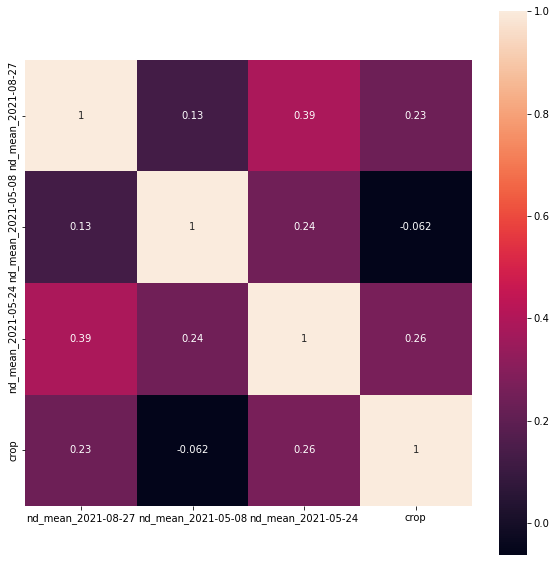

In [9]:
plt.rcParams['figure.figsize']=(10,10)

corr = df_train.loc[:, "nd_mean_2021-08-27":"crop"].corr()
g = sns.heatmap(corr, square = True, annot=True)

Явных зависимостей не выявлено. Приступлю к замене значений временных рядов у которых есть пропуски и они заменены нулями.

In [10]:
df_new_train = df_train.copy()

Пропуски заполнены нулевыми значениями, так же есть отрицательные значения, хотя диапазон nd mean от 0 до 1.

In [11]:
# все отрицательные и нулевые значения заменю на NaN
cols = ['nd_mean_2021-04-16', 'nd_mean_2021-04-19', 'nd_mean_2021-04-22', 'nd_mean_2021-04-26', 'nd_mean_2021-04-28',
         'nd_mean_2021-05-02', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07', 'nd_mean_2021-05-16', 'nd_mean_2021-05-17',
         'nd_mean_2021-05-21', 'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29', 'nd_mean_2021-06-06',
         'nd_mean_2021-06-13', 'nd_mean_2021-06-16', 'nd_mean_2021-06-18', 'nd_mean_2021-06-19', 'nd_mean_2021-06-20',
          'nd_mean_2021-06-22', 'nd_mean_2021-06-25', 'nd_mean_2021-06-27', 'nd_mean_2021-07-07', 'nd_mean_2021-07-08',
          'nd_mean_2021-07-09', 'nd_mean_2021-07-13', 'nd_mean_2021-07-15', 'nd_mean_2021-07-17', 'nd_mean_2021-07-20',
          'nd_mean_2021-07-26', 'nd_mean_2021-07-27', 'nd_mean_2021-07-29', 'nd_mean_2021-07-31', 'nd_mean_2021-08-07', 
          'nd_mean_2021-08-12', 'nd_mean_2021-04-15', 'nd_mean_2021-04-18', 'nd_mean_2021-04-25', 'nd_mean_2021-04-27',
          'nd_mean_2021-04-29', 'nd_mean_2021-04-30', 'nd_mean_2021-06-07', 'nd_mean_2021-06-12', 'nd_mean_2021-06-28',
          'nd_mean_2021-08-01', 'nd_mean_2021-08-11', 'nd_mean_2021-05-01', 'nd_mean_2021-05-03', 'nd_mean_2021-05-10', 
          'nd_mean_2021-05-15', 'nd_mean_2021-06-02', 'nd_mean_2021-06-03', 'nd_mean_2021-07-04', 'nd_mean_2021-08-10',
          'nd_mean_2021-08-23', 'nd_mean_2021-04-20', 'nd_mean_2021-04-23', 'nd_mean_2021-05-09', 'nd_mean_2021-05-19',
          'nd_mean_2021-05-20', 'nd_mean_2021-06-04', 'nd_mean_2021-06-05', 'nd_mean_2021-06-10', 'nd_mean_2021-07-05',
          'nd_mean_2021-08-13',  'nd_mean_2021-08-27', 'nd_mean_2021-05-08', 'nd_mean_2021-05-24']
df_new_train[df_new_train[cols] <= 0] = np.nan

In [12]:
df_new_train["crop"].value_counts().sort_index(ascending=True)

0    726
1    700
2    697
3    655
4    718
5    668
6    666
Name: crop, dtype: int64

In [13]:
# все наны преобразую в среднее значение
for i in df_new_train.columns[df_new_train.isnull().any(axis=0)]:
    df_new_train[i].fillna(df_new_train[i].mean(),inplace=True)

In [14]:
# проверю что с моим датасетом
df_check(df_new_train)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4830 entries, 0 to 4829
Data columns (total 74 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4830 non-null   int64  
 1   area                4830 non-null   int64  
 2   nd_mean_2021-04-16  4830 non-null   float64
 3   nd_mean_2021-04-19  4830 non-null   float64
 4   nd_mean_2021-04-22  4830 non-null   float64
 5   nd_mean_2021-04-26  4830 non-null   float64
 6   nd_mean_2021-04-28  4830 non-null   float64
 7   nd_mean_2021-05-02  4830 non-null   float64
 8   nd_mean_2021-05-04  4830 non-null   float64
 9   nd_mean_2021-05-07  4830 non-null   float64
 10  nd_mean_2021-05-16  4830 non-null   float64
 11  nd_mean_2021-05-17  4830 non-null   float64
 12  nd_mean_2021-05-21  4830 non-null   float64
 13  nd_mean_2021-05-26  4830 non-null   float64
 14  nd_mean_2021-05-27  4830 non-null   float64
 15  nd_mean_2021-05-29  4830 non-null   f

None

Первые строки датасета



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
0,3536,20,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.133690,...,0.108999,0.118854,0.137838,0.171041,0.026784,0.126832,0.614770,0.008857,0.081498,3
1,3739,45,0.332928,0.287182,0.097138,0.152467,0.075484,0.185044,0.140326,0.163340,...,0.134469,0.208268,0.137838,0.171041,0.111148,0.174914,0.179612,0.113071,0.046997,4
2,1294,28,0.013679,0.007055,0.120804,0.037839,0.259125,0.185044,0.037446,0.506516,...,0.084467,0.201038,0.210496,0.130467,0.155225,0.090607,0.054127,0.007437,0.219614,2
3,2859,19,0.105976,0.052500,0.001917,0.011531,0.042316,0.185044,0.114313,0.043604,...,0.183758,0.642226,0.132886,0.171041,0.570928,0.073492,0.378900,0.327677,0.586523,5
4,3685,33,0.130885,0.063492,0.024416,0.185503,0.150671,0.046717,0.254284,0.101479,...,0.206158,0.099058,0.152003,0.073357,0.147842,0.157676,0.012048,0.054223,0.017539,4


Описательная статистика



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
count,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,...,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000
mean,3473.406211,53.871429,0.169452,0.140483,0.178529,0.185503,0.146544,0.185044,0.114313,0.133690,...,0.183758,0.201038,0.137838,0.171041,0.207430,0.148811,0.172921,0.129420,0.147792,2.953830
std,1984.993812,34.191660,0.098733,0.089868,0.124024,0.109825,0.105534,0.131759,0.083859,0.109181,...,0.172158,0.206524,0.140835,0.179367,0.214995,0.139996,0.149834,0.096913,0.143980,2.004587
min,0.000000,10.000000,0.000441,0.000222,0.000527,0.000390,0.000354,0.000267,0.000284,0.000211,...,0.000336,0.000171,0.000207,0.000405,0.000261,0.000285,0.000091,0.000126,0.000203,0.000000
25%,1772.500000,26.000000,0.089240,0.066971,0.083158,0.094366,0.065036,0.077021,0.055371,0.057481,...,0.063236,0.062865,0.055047,0.056469,0.062351,0.058238,0.062928,0.058067,0.055871,1.000000
50%,3489.500000,45.000000,0.169452,0.140483,0.171480,0.185503,0.146544,0.179421,0.114313,0.133690,...,0.146948,0.145439,0.125763,0.133139,0.148611,0.134479,0.148893,0.129420,0.134762,3.000000
75%,5191.750000,76.000000,0.245596,0.202955,0.241323,0.269131,0.192070,0.277772,0.143207,0.162079,...,0.189195,0.201038,0.149199,0.171041,0.207430,0.162134,0.198258,0.162584,0.158424,5.000000
max,6900.000000,140.000000,0.987671,0.760245,0.764437,0.983779,0.668150,0.970286,0.779277,0.782066,...,0.835639,0.892481,0.867968,0.946030,0.939444,0.896011,0.786905,0.766119,0.835383,6.000000


Описательная статистика столбцов object



,.geo
count,4830
unique,4830
top,"{""type"":""Polygon"",""coordinates"":[[[42.49107269..."
freq,1


Количество пропусков в каждом столбце



id                    0
area                  0
nd_mean_2021-04-16    0
nd_mean_2021-04-19    0
nd_mean_2021-04-22    0
                     ..
nd_mean_2021-08-13    0
nd_mean_2021-08-27    0
nd_mean_2021-05-08    0
nd_mean_2021-05-24    0
crop                  0
Length: 74, dtype: int64

Количество уникальных значений



id                    4830
area                   131
nd_mean_2021-04-16    4272
nd_mean_2021-04-19    4081
nd_mean_2021-04-22    4298
                      ... 
nd_mean_2021-08-13    3939
nd_mean_2021-08-27    4054
nd_mean_2021-05-08    4002
nd_mean_2021-05-24    3899
crop                     7
Length: 74, dtype: int64

Количество дубликатов



0

NaN заменены, пропусков нет, нулевых значений тоже. Явной зависимости целевого признака не обнаружено.

In [15]:
df_new_train["crop"].value_counts()

0    726
4    718
1    700
2    697
5    668
6    666
3    655
Name: crop, dtype: int64

## Обучение модели

В качестве признаков буду использовать nd_mean по времени и площадь, а в качестве цели предсказания будет crop - засеянная культура.

In [16]:
X = df_new_train.drop([".geo", "crop"], axis = 1)
y = df_new_train[["crop"]]

In [17]:
# разделю данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3381, 72) (1449, 72)
(3381, 1) (1449, 1)


In [18]:
y.value_counts()

crop
0       726
4       718
1       700
2       697
5       668
6       666
3       655
dtype: int64

In [19]:
# стандартизация данных
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

In [20]:
model_rfc = RandomForestClassifier(n_estimators = 100, random_state=RANDOM_STATE)
model_knc = KNeighborsClassifier(n_neighbors = 18)
model_lr = LogisticRegression(verbose=1, n_jobs=-1, random_state=RANDOM_STATE) 
model_svc = svm.SVC(random_state=RANDOM_STATE)
model_HGBGT = HistGradientBoostingClassifier(max_iter=1500, random_state=RANDOM_STATE)
model_LGBM = LGBMClassifier(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
model_xgb_cl = xgb.XGBClassifier()

In [21]:
%%time
model_rfc.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_rfc = model_rfc.predict(X_test_scaled)

model_knc.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_knc = model_knc.predict(X_test_scaled)

model_lr.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_lr = model_lr.predict(X_test_scaled)

model_svc.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_svc = model_svc.predict(X_test_scaled)

model_HGBGT.fit(X_train, np.ravel(y_train, order='C'))
pred_HGBGT = model_HGBGT.predict(X_test)

model_LGBM.fit(X_train, np.ravel(y_train, order='C'))
pred_LGBM = model_LGBM.predict(X_test)

model_xgb_cl.fit(X_train, np.ravel(y_train, order='C'))
pred_xgb_cl = model_xgb_cl.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished


[LightGBM] [Warning] Unknown parameter: n_repeats
[LightGBM] [Warning] Unknown parameter: n_splits
CPU times: total: 2min 35s
Wall time: 28.3 s


In [22]:
print(model_rfc,'\n', recall_score(y_test, pred_rfc, average="macro", zero_division=0))
print(model_knc,'\n', recall_score(y_test, pred_knc, average="macro", zero_division=0))
print(model_lr,'\n', recall_score(y_test, pred_lr, average="macro", zero_division=0))
print(model_svc,'\n', recall_score(y_test, pred_svc, average="macro", zero_division=0))
print(model_HGBGT,'\n', recall_score(y_test, pred_HGBGT, average="macro", zero_division=0))
print(model_LGBM,'\n', recall_score(y_test, pred_LGBM, average="macro", zero_division=0))
print(model_xgb_cl,'\n', recall_score(y_test, pred_xgb_cl, average="macro", zero_division=0))

RandomForestClassifier(random_state=12345) 
 0.9522332269636379
KNeighborsClassifier(n_neighbors=18) 
 0.8990165282130084
LogisticRegression(n_jobs=-1, random_state=12345, verbose=1) 
 0.9289946048888316
SVC(random_state=12345) 
 0.9456911238734023
HistGradientBoostingClassifier(max_iter=1500, random_state=12345) 
 0.9585806340482231
LGBMClassifier(n_repeats=3, n_splits=10, random_state=12345) 
 0.9571237492739639
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=na

<h4>HistGradientBoostingClassifier

Лучшей моделью себя показала HistGradientBoostingClassifier на ней будет проверяться тестовый датафрейм

In [23]:
df_check(df_test)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 73 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2071 non-null   int64  
 1   area                2071 non-null   int64  
 2   nd_mean_2021-04-16  2071 non-null   float64
 3   nd_mean_2021-04-19  2071 non-null   float64
 4   nd_mean_2021-04-22  2071 non-null   float64
 5   nd_mean_2021-04-26  2071 non-null   float64
 6   nd_mean_2021-04-28  2071 non-null   float64
 7   nd_mean_2021-05-02  2071 non-null   float64
 8   nd_mean_2021-05-04  2071 non-null   float64
 9   nd_mean_2021-05-07  2071 non-null   float64
 10  nd_mean_2021-05-16  2071 non-null   float64
 11  nd_mean_2021-05-17  2071 non-null   float64
 12  nd_mean_2021-05-21  2071 non-null   float64
 13  nd_mean_2021-05-26  2071 non-null   float64
 14  nd_mean_2021-05-27  2071 non-null   float64
 15  nd_mean_2021-05-29  2071 non-null   f

None

Первые строки датасета



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-19,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24
0,611,26,0.196691,0.000000,0.259303,0.052522,0.133353,0.000000,0.058353,0.273228,...,0.030786,0.159111,0.127732,0.188092,0.000000,0.200005,0.714292,0.084197,0.157733,0.197326
1,6417,98,0.091192,0.000000,0.125823,0.000000,0.027636,0.433244,0.344155,0.461029,...,0.064743,0.000000,0.039850,0.067910,0.084682,0.025694,0.000000,0.108945,0.141947,0.000000
2,3352,21,0.000000,0.033368,0.285057,0.028275,0.089219,0.080082,0.220537,0.154620,...,0.129930,0.230840,0.034613,0.044020,0.762353,0.167975,0.037838,0.158279,0.073814,0.185710
3,4224,18,0.111243,0.201012,0.000000,0.000000,0.107940,0.000000,0.213204,0.031273,...,0.076965,0.045298,0.000000,0.114008,0.059159,0.058423,0.108990,0.237742,0.000000,0.000000
4,3102,53,0.000000,0.234954,0.000000,0.305964,0.268629,0.305554,0.131192,0.009491,...,0.066117,0.089418,0.024093,0.209458,0.033658,0.000000,0.048622,0.121296,0.010354,0.000000


Описательная статистика



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-19,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24
count,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,...,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000
mean,3395.411878,54.217769,0.148241,0.116868,0.159880,0.165898,0.124731,0.164807,0.094929,0.112938,...,0.173881,0.160224,0.173516,0.114310,0.148702,0.180408,0.123912,0.148208,0.106996,0.127262
std,2008.629732,34.676356,0.112813,0.103577,0.137519,0.125306,0.117672,0.143268,0.100215,0.124790,...,0.195500,0.191212,0.224598,0.154860,0.200858,0.235620,0.154632,0.164599,0.105031,0.163934
min,8.000000,10.000000,-0.019319,-0.038503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1616.500000,26.000000,0.044803,0.022658,0.049085,0.052615,0.028041,0.043806,0.014591,0.016087,...,0.028322,0.021386,0.017169,0.013253,0.017982,0.017297,0.015566,0.021109,0.019801,0.013080
50%,3383.000000,43.000000,0.136773,0.091653,0.131273,0.153998,0.097623,0.127054,0.071298,0.080724,...,0.100620,0.089418,0.086228,0.069415,0.077317,0.087281,0.074553,0.091703,0.080956,0.074491
75%,5112.000000,80.000000,0.246197,0.200956,0.242073,0.269303,0.186115,0.284445,0.143078,0.165593,...,0.227868,0.200805,0.195967,0.146115,0.172683,0.199243,0.164206,0.205333,0.162071,0.161308
max,6898.000000,140.000000,0.844356,0.650111,0.744053,0.595886,0.709082,0.896641,0.815071,0.756342,...,0.848197,0.818625,0.883888,0.888599,0.963164,0.964003,0.763992,0.811098,0.589224,0.781927


Описательная статистика столбцов object



,.geo
count,2071
unique,2071
top,"{""type"":""Polygon"",""coordinates"":[[[35.96545926..."
freq,1


Количество пропусков в каждом столбце



id                    0
area                  0
nd_mean_2021-04-16    0
nd_mean_2021-04-19    0
nd_mean_2021-04-22    0
                     ..
nd_mean_2021-07-05    0
nd_mean_2021-08-13    0
nd_mean_2021-08-27    0
nd_mean_2021-05-08    0
nd_mean_2021-05-24    0
Length: 73, dtype: int64

Количество уникальных значений



id                    2071
area                   131
nd_mean_2021-04-16    1832
nd_mean_2021-04-19    1744
nd_mean_2021-04-22    1862
                      ... 
nd_mean_2021-07-05    1705
nd_mean_2021-08-13    1704
nd_mean_2021-08-27    1721
nd_mean_2021-05-08    1748
nd_mean_2021-05-24    1675
Length: 73, dtype: int64

Количество дубликатов



0

In [31]:
X_test_TST = df_test.drop([".geo"], axis = 1)

In [32]:
X_test_TST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 72 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2071 non-null   int64  
 1   area                2071 non-null   int64  
 2   nd_mean_2021-04-16  2071 non-null   float64
 3   nd_mean_2021-04-19  2071 non-null   float64
 4   nd_mean_2021-04-22  2071 non-null   float64
 5   nd_mean_2021-04-26  2071 non-null   float64
 6   nd_mean_2021-04-28  2071 non-null   float64
 7   nd_mean_2021-05-02  2071 non-null   float64
 8   nd_mean_2021-05-04  2071 non-null   float64
 9   nd_mean_2021-05-07  2071 non-null   float64
 10  nd_mean_2021-05-16  2071 non-null   float64
 11  nd_mean_2021-05-17  2071 non-null   float64
 12  nd_mean_2021-05-21  2071 non-null   float64
 13  nd_mean_2021-05-26  2071 non-null   float64
 14  nd_mean_2021-05-27  2071 non-null   float64
 15  nd_mean_2021-05-29  2071 non-null   float64
 16  nd_mea

In [33]:
pred_HGBGT_test = model_HGBGT.predict(X_test_TST)

In [34]:
filename = 'sample_solution.csv'
submission = pd.read_csv(filename)
pred_HGBGT_test = model_HGBGT.predict(X_test_TST)
submission['crop'] = pred_HGBGT_test
submission.to_csv('./my_submission.csv', index=False)